In [1]:
# Importamos las librerias necesarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dataframe_image as dfi
import os
import seaborn as sns
from IPython.display import display, Markdown, Latex

In [2]:
# Definiciones del script

# Directorio de imagenes
dirImg = './imagenes'

# Mode
mode = 1

# CSV
csv1 = './data/data.{0}.csv'.format(mode)

In [3]:
# Creamos el directorio de imagenes
if not os.path.exists(dirImg):
	os.mkdir(dirImg)
else :
	os.system("rm -r " + dirImg)
	os.mkdir(dirImg)

In [4]:
# Obtenemos los datos del archivo CSV para un dataset
dataset1 = pd.read_csv(csv1, sep=',', header=None)

# Agregamos los nombres de las columnas
dataset1.columns = ['Flag', 'Value', 'Diff', 'nTrap', 'Process', 'Time']

# Remove column Flag
dataset1 = dataset1.drop('Flag', axis=1)

print("Total rows: {0}".format(len(dataset1)))

Total rows: 27040


In [5]:
# Eliminamos los valores donde el overhead o time es negativo
#dataset1 = dataset1[dataset1['Time'] >= 0]
#print("Total rows: {0}".format(len(dataset1)))

In [6]:
# Obtenemos los valores unicos de la columna Process y N
process = dataset1['Process'].unique()
nTrap = dataset1['nTrap'].unique()

process = sorted(process)
nTrap = sorted(nTrap)

datasetsByCore = []

for p in process:
	for n in nTrap:
		datasetsByCore.append(dataset1[(dataset1['Process'] == p) & (dataset1['nTrap'] == n)])

print("Valid: " + str(len(process) * len(nTrap) == len(datasetsByCore)))


Valid: True


In [7]:
finalData = []

min_process = dataset1['Process'].min()

ref_dataset = dataset1[dataset1['Process'] == min_process]

ref_times = ref_dataset.groupby('nTrap')['Time'].max()

for (nTrap_value, process_value), group in dataset1.groupby(['nTrap', 'Process']):

	max_time = group['Time'].max()

	ref_time = ref_times.get(nTrap_value, None)

	if ref_time and max_time:
		speedup = ref_time / max_time
		efficiency = speedup / process_value if process_value != 0 else 0
	else:
		speedup = None
		efficiency = None

	group = group[group['Diff'] != -1]

	error = abs(group['Diff'].min())
	quality = 1 / (max_time * error) if max_time and error else None

	finalData.append([process_value, nTrap_value, max_time, ref_time, speedup, efficiency, error, quality])

final_df = pd.DataFrame(finalData, columns=['Process', 'nTrap', 'MaxTime', 'RefTime', 'Speedup', 'Efficiency', 'Error', 'Quality'])

display(final_df)

,Process,nTrap,MaxTime,RefTime,Speedup,Efficiency,Error,Quality
0,1,1,0.000002,0.000002,1.000000,1.000000,6.710886e+07,7.450581e-03
1,2,1,0.028721,0.000002,0.000070,0.000035,6.710886e+07,5.188246e-07
2,3,1,0.030637,0.000002,0.000065,0.000022,6.710886e+07,4.863780e-07
3,4,1,0.035899,0.000002,0.000056,0.000014,6.710886e+07,4.150857e-07
4,5,1,0.030037,0.000002,0.000067,0.000013,6.710886e+07,4.960935e-07
...,...,...,...,...,...,...,...,...
827,60,1000000000000,304.483375,17989.825943,59.083114,0.984719,2.211705e-05,1.484941e+02
828,61,1000000000000,311.165537,17989.825943,57.814326,0.947776,2.211705e-05,1.453053e+02
829,62,1000000000000,299.108917,17989.825943,60.144733,0.970076,2.211705e-05,1.511623e+02
830,63,1000000000000,296.700822,17989.825943,60.632882,0.962427,2.211705e-05,1.523892e+02


In [8]:
# Ajustamos algun dato que falle

# prevOne = final_df.loc[(final_df['Process'] == 43) & (final_df['nTrap'] == 1), 'Efficiency'].values[0]
# nextOne = final_df.loc[(final_df['Process'] == 45) & (final_df['nTrap'] == 1), 'Efficiency'].values[0]

# final_df.loc[(final_df['Process'] == 44) & (final_df['nTrap'] == 1), 'Efficiency'] = (prevOne + nextOne) / 2

# prevOne = final_df.loc[(final_df['Process'] == 7) & (final_df['nTrap'] == 1), 'Efficiency'].values[0]
# nextOne = final_df.loc[(final_df['Process'] == 9) & (final_df['nTrap'] == 1), 'Efficiency'].values[0]

# final_df.loc[(final_df['Process'] == 8) & (final_df['nTrap'] == 1), 'Efficiency'] = (prevOne + nextOne) / 2

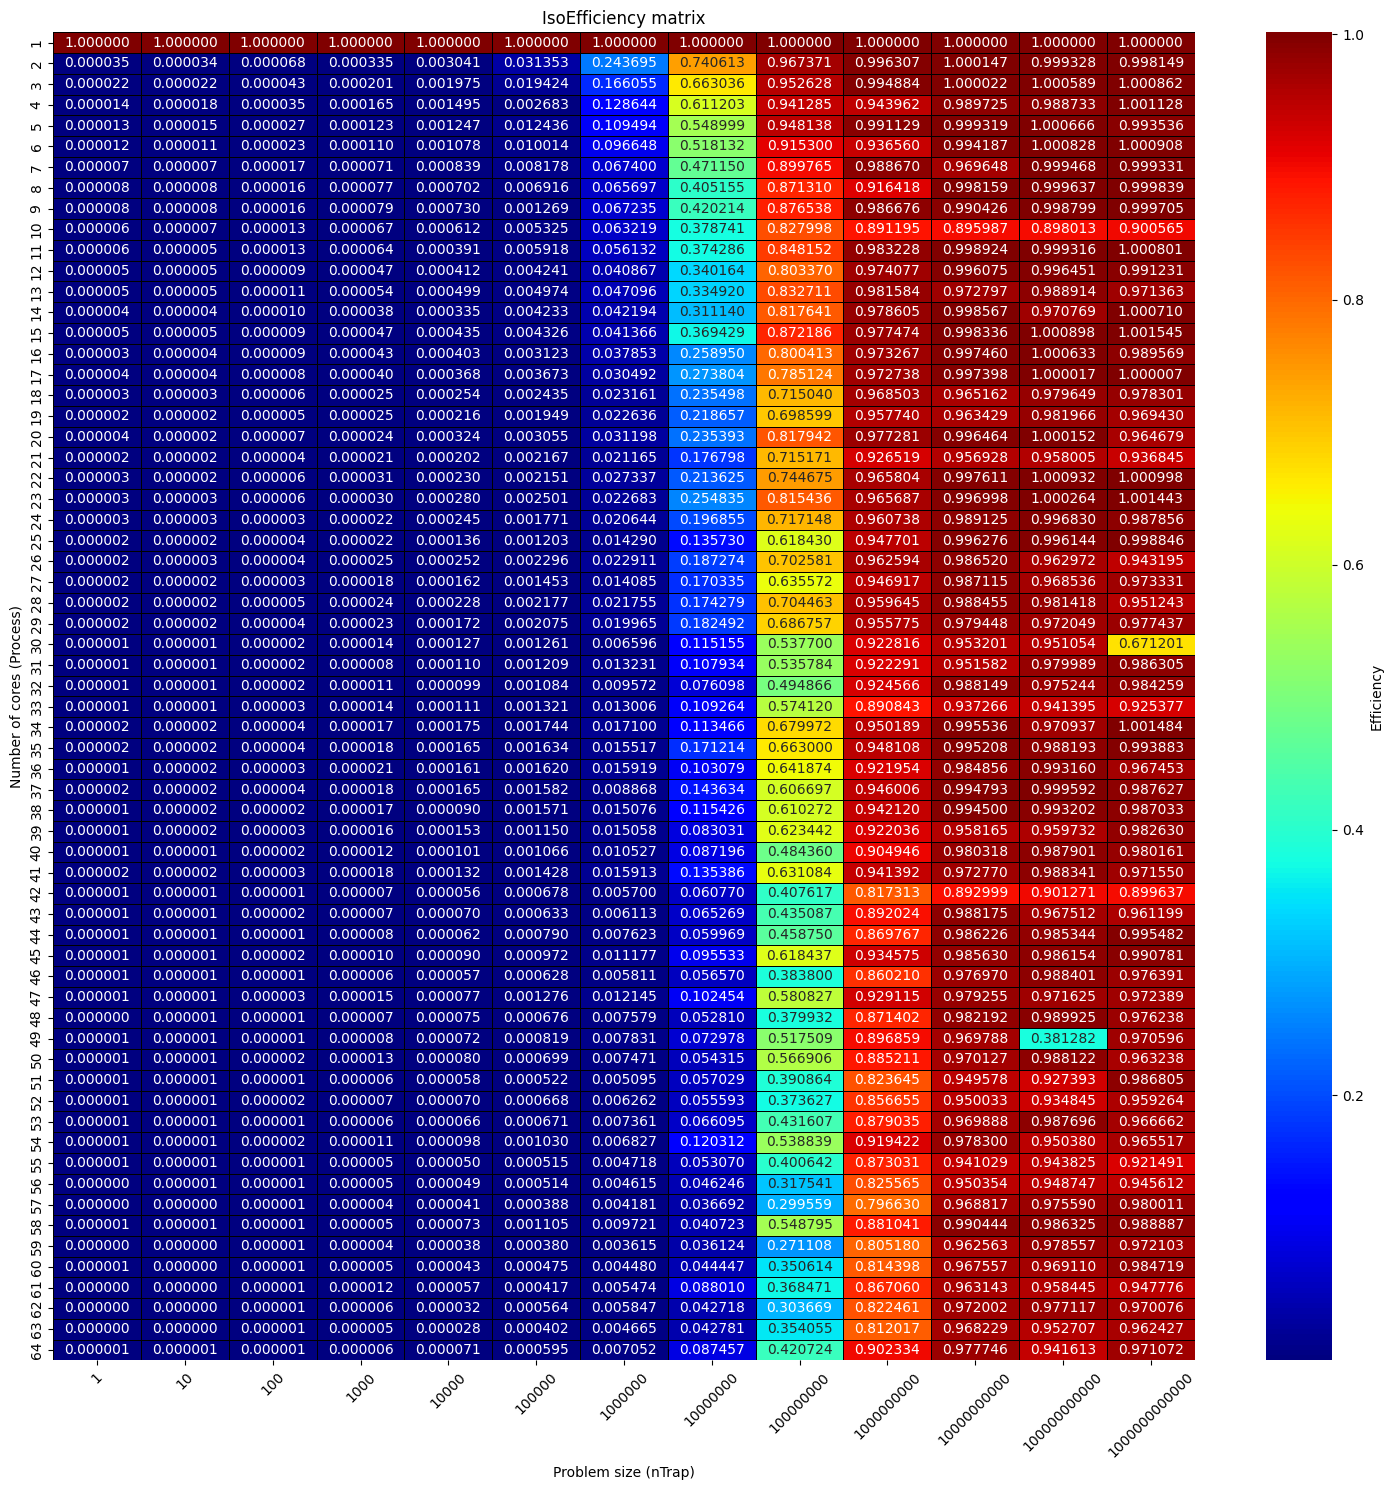

In [9]:
efficiency_matrix = final_df.pivot(index='Process', columns='nTrap', values='Efficiency')

# Configura el tamaño de la figura
plt.figure(figsize=(15, 15))

# Usa el heatmap de Seaborn
ax = sns.heatmap(efficiency_matrix, annot=True, fmt=".6f", cmap='jet', cbar_kws={'label': 'Efficiency'}, linewidths=0.5, linecolor='black')

# Agrega títulos y etiquetas
ax.set_title("IsoEfficiency matrix")
ax.set_xlabel("Problem size (nTrap)")
ax.set_ylabel("Number of cores (Process)")

# Rotación de las etiquetas de eje X para mayor claridad
plt.xticks(rotation=45)

# Guarda y muestra la figura
plt.tight_layout()
plt.savefig(f'{dirImg}/iso_efficiency_matrix.{mode}.png')
plt.show()


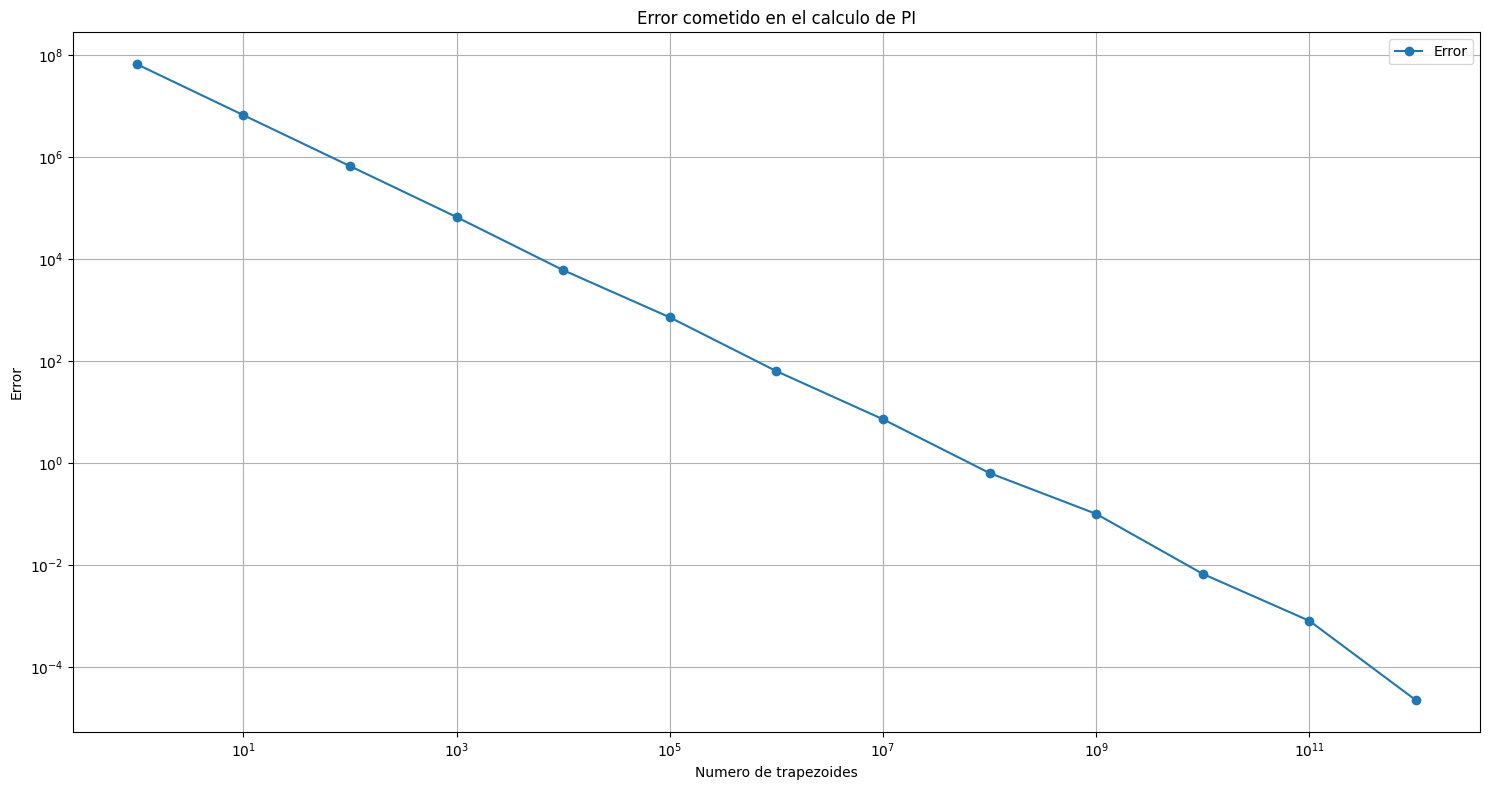

In [10]:
# Graficamos el error cometido en el calculo de PI para cada valor de N

# Filtramos los los valores que tengan un valor de -1 en la columna Diff y para el proceso 1
tempData = final_df[(final_df['Process'] == 64)]

# Valores de N
xValues = tempData['nTrap']
yValues = tempData['Error']

plt.figure(figsize=(15, 8))

plt.plot(xValues, yValues, marker='o', label='Error')

plt.xscale('log')
plt.yscale('log')

plt.title('Error cometido en el calculo de PI')
plt.xlabel('Numero de trapezoides')
plt.ylabel('Error')

plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig(dirImg + '/error.{0}.png'.format(mode))

plt.show()


In [11]:
# Dame los datos de final_df para Process = 9 y 64
final_df_9 = final_df[final_df['Process'] == 9]
final_df_64 = final_df[final_df['Process'] == 64]

display(final_df_9)
display(final_df_64)

,Process,nTrap,MaxTime,RefTime,Speedup,Efficiency,Error,Quality
8,9,1,0.028185,0.000002,0.000071,0.000008,6.710886e+07,5.286912e-07
72,9,10,0.028219,0.000002,0.000071,0.000008,6.710885e+06,5.280543e-06
136,9,100,0.028122,0.000004,0.000142,0.000016,6.710883e+05,5.298758e-05
200,9,1000,0.028058,0.000020,0.000713,0.000079,6.710877e+04,5.310850e-04
264,9,10000,0.028171,0.000185,0.006567,0.000730,6.095122e+03,5.823919e-03
328,9,100000,0.161659,0.001846,0.011419,0.001269,7.229883e+02,8.555962e-03
392,9,1000000,0.030277,0.018321,0.605113,0.067235,6.356351e+01,5.196122e-01
456,9,10000000,0.047616,0.180080,3.781922,0.420214,7.229052e+00,2.905131e+00
520,9,100000000,0.227863,1.797575,7.888841,0.876538,6.353722e-01,6.907135e+00
584,9,1000000000,2.021912,17.954740,8.880080,0.986676,1.005710e-01,4.917734e+00


,Process,nTrap,MaxTime,RefTime,Speedup,Efficiency,Error,Quality
63,64,1,0.048530,0.000002,0.000041,6.439316e-07,6.710886e+07,3.070505e-07
127,64,10,0.047803,0.000002,0.000042,6.537247e-07,6.710885e+06,3.117203e-06
191,64,100,0.048456,0.000004,0.000083,1.289830e-06,6.710883e+05,3.075196e-05
255,64,1000,0.048540,0.000020,0.000412,6.437989e-06,6.710877e+04,3.069877e-04
319,64,10000,0.040643,0.000185,0.004552,7.112233e-05,6.095122e+03,4.036750e-03
383,64,100000,0.048452,0.001846,0.038100,5.953057e-04,7.229883e+02,2.854677e-02
447,64,1000000,0.040593,0.018321,0.451334,7.052093e-03,6.356351e+01,3.875618e-01
511,64,10000000,0.032173,0.180080,5.597240,8.745687e-02,7.229052e+00,4.299591e+00
575,64,100000000,0.066759,1.797575,26.926332,4.207239e-01,6.353722e-01,2.357556e+01
639,64,1000000000,0.310908,17.954740,57.749366,9.023338e-01,1.005710e-01,3.198124e+01


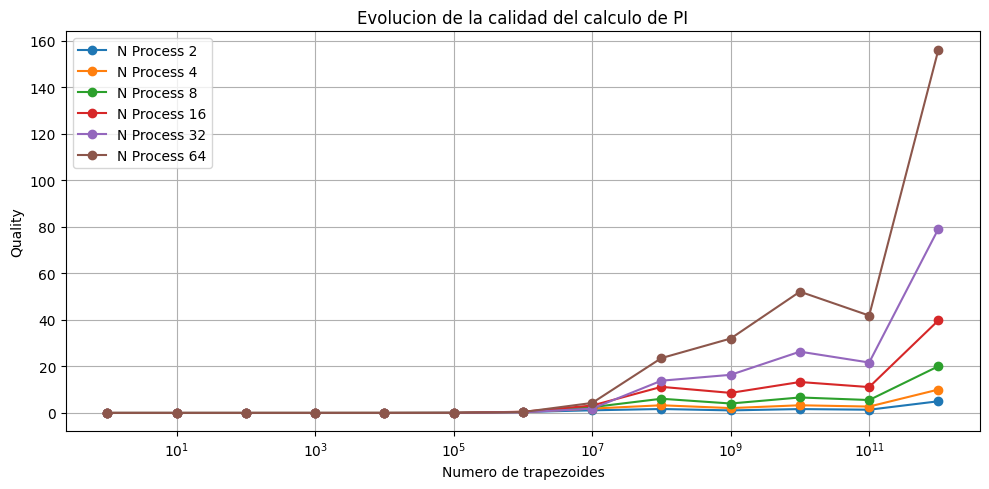

In [12]:
# Grafica la evolucion de la calidad del calculo de PI en funcion del numero de trapezoides para cada numero de procesos
# Usar solo los valores de process potencia de 2

temp_process = [2, 4, 8, 16, 32, 64]

plt.figure(figsize=(10, 5))

for i in range(len(temp_process)):

	tempData = final_df[(final_df['Process'] == temp_process[i])]

	xValues = tempData['nTrap']
	yValues = tempData['Quality']

	plt.plot(xValues, yValues, marker='o', label='N Process ' + str(temp_process[i]))

plt.xscale('log')

plt.title('Evolucion de la calidad del calculo de PI')
plt.xlabel('Numero de trapezoides')
plt.ylabel('Quality')

plt.legend()
plt.grid()
plt.tight_layout()

plt.savefig(dirImg + '/quality.{0}.png'.format(mode))

plt.show()

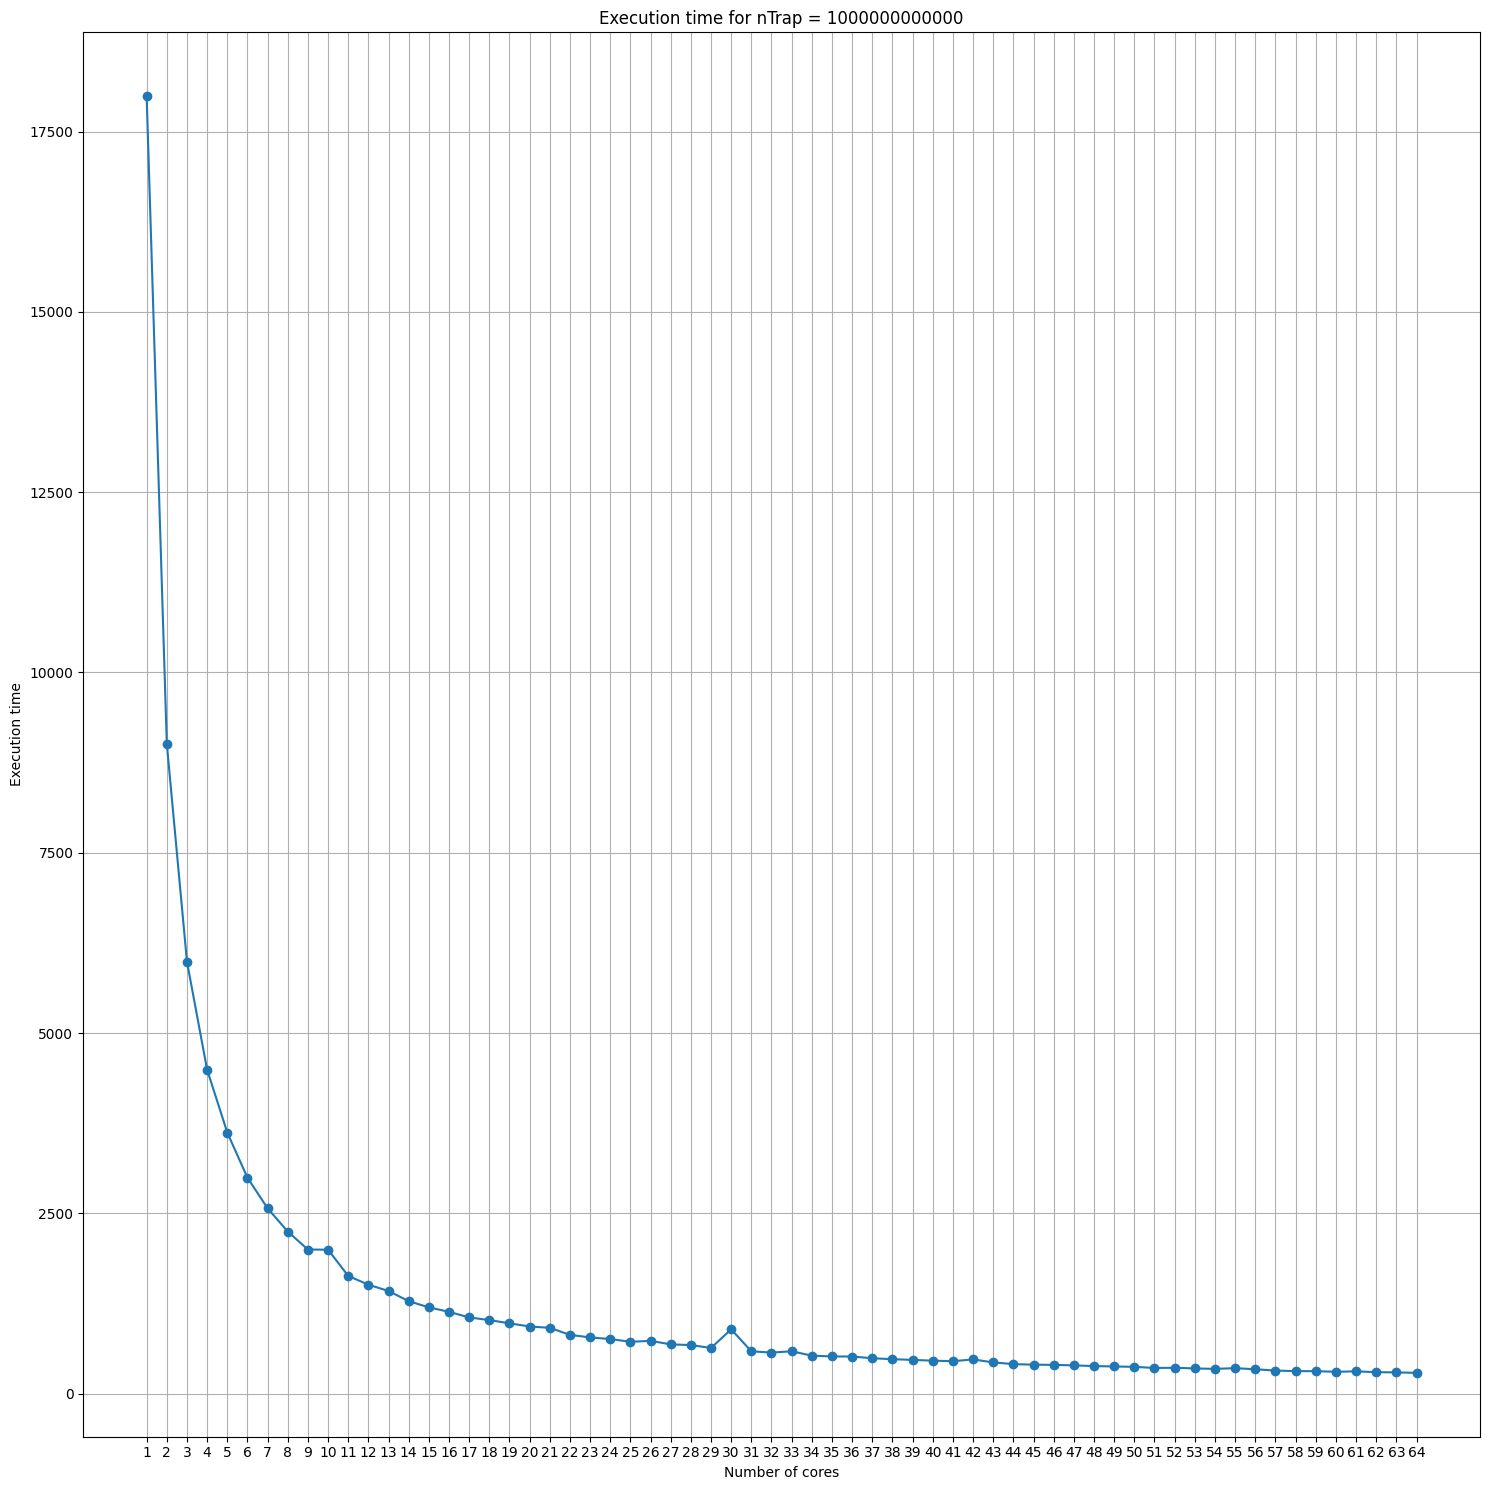

In [13]:
plt.figure(figsize=(15, 15))

maxN = final_df['nTrap'].max()

xvalues = range(len(process))
yvalues = final_df[final_df['nTrap'] == maxN]['MaxTime']

plt.plot(xvalues, yvalues, marker='o')

plt.title('Execution time for nTrap = ' + str(maxN))
plt.xlabel('Number of cores')
plt.ylabel('Execution time')

plt.xticks(xvalues, process)

plt.grid()
plt.tight_layout()

plt.savefig(dirImg + '/execution_time.{0}.png'.format(mode))

plt.show()